# Hevia_et_al_2022: Algorithms and data description
author: "f.u."
date: March 2022

### Reference: Hevia et al. (2022) The neurogenic fate of the hindbrain boundaries relies on Notch3-dependent asymmetric cell divisions.

## Main data structures

Here we load and describe the main data structures used in the rest of the document.

### Packages used

In [55]:

library(dplyr)
library(tidyr)
# library(rgl)  not used here
# library(Rvcg) not used here
library(zoo)


## Cell tracking data

Data created by Mamut software was read into R and included in several data structures. We list here the main ones. Original data and processing algorithms are available upon request.

+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| `tracksTable` | A data frame (118 by 4), one track per row, columns:\                                                                                                            |
|               | `trackLabel`: A label ID\                                                                                                                                        |
|               | `TrackType`: One of "PN", "PQ", "N", "CN", "PP", "IND1", "NONE"\                                                                                                 |
|               | `divTime`: Frame of cell division or 9999 if no division\                                                                                                        |
|               | `plfType`: One of "PLF" "NPLF" ""                                                                                                                                |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| `tracks`      | A list of 118 data frames, one per track, named by trackLabel, each one with columns `POSITION_X` `POSITION_Y` `POSITION_Z` `POSITION_T`, space-time coordinates |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|               |                                                                                                                                                                  |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| `cellsTable`  | A data frame (264 by 9), one row for each cell, columns:\                                                                                                        |
|               | `cellLabel`: A label ID, the track ID followed by 00: progenitor, 01, 02: descend\                                                                               |
|               | `track`: its track ID\                                                                                                                                           |
|               | `trackType`: as before\                                                                                                                                          |
|               | `cellType`: One of "P" "D1" "D2" "21" "22" "11" "12"\                                                                                                            |
|               | `cellLastFrame`: The last frame where the cell was observed.\                                                                                                    |
|               | `hasDivision`: TRUE or FALSE\                                                                                                                                    |
|               | `plfType`: as before\                                                                                                                                            |
|               | `cellFirstFrame`: First appearance of the cell.\                                                                                                                 |
|               | `isShort`: Is it a short lived division? Yes if both descendants live less than 3 hpf.                                                                           |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| `cells`       | A list of (264) data frames, each with 4 columns (x, y, z, t coordinates) and as many rows as frames the cell has been spotted.                                  |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+

In [56]:
load("data/tracking.RData")

# frame num to hpf conversion 
# t0 is 32hpf, each frame adds 3.5 minutes 
frame2hpf <- function(fr) return(32+3.5*fr/60)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Colors
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cellColor <- list(PQ= "black",PN=  "#4C5E85",IND1=  "white",
                  PP="#48125E", CN="darkgrey", N="darkgrey", NONE="white", 
                  PD="#5D9B90", ND="#95CC86")
plfColor <- list(NPLF="darkgrey", PLF="#4C5E85")

vio <- rgb(18761,4626,24158,maxColorValue = 2^16)
gri <- rgb(18247,30069,37779,maxColorValue = 2^16)
gri2 <- rgb(28013,50115,35723,maxColorValue = 2^16)
yil <- rgb(63993,59881,30069,maxColorValue = 2^16)
cols <- c(vio, gri, gri2, yil)
paletaCova <- colorRampPalette(cols, space="Lab")

paletaPP <- colorRampPalette(c("white", cellColor$PP), space="Lab")
paletaPN <- colorRampPalette(c("white", cellColor$PN), space="Lab")



## Ventricular surface modeling data

Starting with the WRL files produced by Imaris (available upon request), one ventricular shape for each one of 45 frames, we used MeshLab to convert them to PLY format, we read it into R using function `readAllPlys()` and package `Rvcg`.

Then some cleaning was done using functions `remBoxPoints()` and `changeZsign()` and package `rgl`.

The meshes produced (also available upon request) were sectioned by vertical plane at y=39. The resulting sections of 45 shapes are stored in `sec39`.

The sections were used to measure the distance from a cell in a given time frame to the ventricular surface. This is stored in

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| `cellPaths` | A 3 way array, frames by cells by coords, (194 by 264 by 7).                                                                                                                            |
|             |                                                                                                                                                                                         |
|             | `coords` are `x, y, z` (cell position), `nx, ny, nz` (for the nearest point in the ventricular surface), and dist from the cell to the nearest point (see function `fillNearest` below. |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| `sec39`     | List of 45 sections at AP=39 of the ventricular shape every 5 frames.                                                                                                                   |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

In [57]:
load("data/ventrSurf.RData")


## Ventricular surface modeling algorithms

In [58]:

# functions in this chunk are not run in this document, 
# they are listed just as documentation.

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## read all ply files and store meshes in VSmeshList
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

remBoxPoints <- function(msh, clip=0.98){
  # given a mesh3d return it removing 
  # all vertices and faces in the extreme values of coords
  minmax = apply(msh$vb, 1, FUN = function(coor){fivenum(coor)[c(1,5)]}) # is 2x4
  cnt = apply(minmax, 2, mean)
  hwd = apply(minmax, 2, FUN = function(itv){(itv[2]-itv[1])/2}) # half width, 1x4
  mins = (cnt - clip*hwd)[1:3]
  mxs = (cnt + clip*hwd)[1:3]
  # print(mins)
  keepone = function(vtx){ # 1 if vtx is to keep, 0 if not, vtx is 1x3
    if (all(((mins<vtx)&(vtx<mxs)))) return(1)
    else return(0)
  }
  ret = clipMesh3d(msh, function(ar3xv){apply(ar3xv, 1, keepone)},
                   bound = 0.5, greater = TRUE,
                   attribute = "vertices")
  return(ret)
}


readAllPlys <- function(isolate=TRUE){
  # read all ply files and store meshes in VSmeshList
  # When isolate, just the main connex mesh component is kept 
  plys <- dir("plys")
  meshList <- lapply(plys,
                     function(ply){
                       message("Preparing mesh ", ply)
                       vM = vcgPlyRead(paste("plys/", ply, sep=''))
                       vM = remBoxPoints(vM)
                       if (isolate) 
                         vM = vcgIsolated(changeZsign(vM))
                       else
                         vM = changeZsign(vM)
                       #return(unCapSupVentr(vM))
                       return(vM)
                     }
  )
  # rename frames to match cell data, first frame is 000, last is 217
  seqfr = c(0, seq(4,214, by=5), 217)
  seqfr = paste0("F", formatC(seqfr, width = 3, flag = "0"))
  names(meshList) <- seqfr
  return(meshList)
}
# VSmeshListIsol <- readAllPlys(isolate=TRUE)
# VSmeshListNoIs <- readAllPlys(isolate=FALSE)
# removed! load ("./allWithMeshesAndDists.RData") if needed

changeZsign <- function(amesh){
  # meshes as produced by Imaris have the DV axis in the wrong direction
  amesh$vb[3,] <- (-1)*amesh$vb[3,]
  amesh$normals[3,] <- (-1)*amesh$normals[3,]
  bmesh <- tmesh3d(vertices = amesh$vb, indices = amesh$it, normals = amesh$normals)
  bmesh$remvert <- amesh$remvert
  return(bmesh)
}

## to show the meshes
viewVSmeshes <- function(mshL = VSmeshListIsol, folder=NULL, boxed=TRUE){
  for (mshnum in seq(1,length(mshL),by=1)){
    msh = mshL[[mshnum]]
    if (boxed)
      plot3d(msh, col = "red", 
             xlim = c(0,250), ylim = c(0,50), zlim = c(-120,-60), aspect="iso",
             # forceClipregion = FALSE,
             xlab='L/M', ylab='A/P', zlab='D/V',
             main=names(mshL)[mshnum])
    else
      plot3d(msh, col = "red", type = 'shade',
             xlim = c(0,250), ylim = c(0,50), zlim = c(-120,-60), aspect="iso",
             box = FALSE, axes = FALSE,
             # forceClipregion = FALSE,
             xlab='L/M', ylab='A/P', zlab='D/V',
             main=names(mshL)[mshnum])
    Sys.sleep(1)
    if (!is.null(folder))
      snapshot3d(paste0(folder, "/", names(mshL)[mshnum], ".png"))
  }
}
# viewVSmeshes(mshL = VSmeshListIsol, folder="pngsIsol")
# viewVSmeshes(mshL = VSmeshListNoIs, folder="pngsNoIs")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# extract and plot vertical AP sections of the mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sectionMesh <- 
  function(aMesh, y0c=30){
    # vertical section at y0c, return a of segments x0,z0,x1,z1
    # aMesh$vb[,n] is 4-vec of coords for vertex n
    # aMesh$it[,1] is a face, 3-vec integers for the vertices num
    message("Compute section at y=", y0c)
    keepit = function(fce){ # true if face cuts plane y0
      # face is a vector of 3 vertice numbers
      ys <- aMesh$vb[2,fce][1:3] # the y values of the 3 vtx
      if ((min(ys)<=y0c)&&(y0c<=max(ys))) return(TRUE)
      else return(FALSE)}
    cutSeg <- function(p0,p1){ # given points p0 p1, return xz cut with y0c or NULL
      if ((min(p0[2],p1[2])<=y0c)&&(y0c<=max(p0[2],p1[2]))){
        if (p0[2]==p1[[2]]) return(p0[c(1,3)])
        else {
          pc = p0 + (p1-p0)*(y0c-p0[2])/(p1[2]-p0[2])
          return(pc[c(1,3)])}}
      else return(NULL)
    }
    cutFace <- function(fce){ # given face that cuts, return x0,z0,x1,z1
      res = rep(0,4)
      if (!is.null(p1 <- cutSeg(aMesh$vb[,fce[1]],aMesh$vb[,fce[2]]))){
        res[1:2] <- p1
        if (!is.null(p2 <- cutSeg(aMesh$vb[,fce[2]],aMesh$vb[,fce[3]]))) 
          res[3:4] <- p2
        else { 
          p2 <- cutSeg(aMesh$vb[,fce[3]],aMesh$vb[,fce[1]])
          res[3:4] <- p2
        }
      }
      else{
        res[1:2] <- cutSeg(aMesh$vb[,fce[2]],aMesh$vb[,fce[3]])
        res[3:4] <- cutSeg(aMesh$vb[,fce[3]],aMesh$vb[,fce[1]])
      }
      return(res)
    }
    clm = apply(aMesh$it,2,FUN=keepit) # the faces that cut
    lins = apply(aMesh$it[,clm],2,FUN=cutFace)
    return(lins)
  } ## end sectionMesh()


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Distances from cell to ventricular surface
# to plot distances over time
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nearestPoint <- function(pnt, amesh){ 
  # return the nearest mesh vtx to pnt and distance: 1x4
  # brute force approach
  sqdsts <- apply(amesh$vb, 2, function(vtx) sum((vtx[1:3]-pnt)^2))
  minsqdst <- min(sqdsts)
  ind <- match(minsqdst, sqdsts)
  return(c(amesh$vb[,ind][1:3], sqrt(minsqdst)))
}

# Warning: this is very data dependent, 
# now we have VSs F000, F004, ..., F214, F217
fillNearest <- function(mshList = VSmeshListIsol, cPth = cellPaths){  
  # fill nearest point coords and dist in cellPaths and return it
  # cPth  is 3d array: frame x cell x 3/7coords
#  dimnames(cPth) <- dimnames(cellPaths)
  frNam <- names(mshList[-(1:5)]) # just 24 ... 217
  frNum <- as.character( as.numeric(substr(frNam,2,4)))
  message("Doing frames ", paste(frNam, collapse = ' '))
  for (frI in 1:length(frNam)){
    message("Filling frame ", frNam[frI])
    cellsCoords <- cPth[frNum[frI],,]
    cCN <- apply(cellsCoords, 1, 
                 function(crds){
                   if (is.na(crds[1])) 
                     return(crds)
                   else {
                     res <- c(crds[1:3], nearestPoint(crds[1:3], 
                                                      mshList[[frNam[frI]]]))
                     return(res)
                   }
                 })
    cPth[frNum[frI],,] <- t(cCN)
  }
  return(cPth)
}
# This was used to put nearest point and distance into cellPaths$coords columns: 
#    cellPaths <- fillNearest(cPth = cellPaths)



## Data on cell differentiation

Data for Figures 2C and Sup 3 A-B

In [59]:

diffCounts <- read.csv("data/diffCounts.csv",
                       stringsAsFactors=TRUE)
diffCounts$percHuC <- 
  100*diffCounts$Huc / (diffCounts$Huc + diffCounts$noHuC)

percBoundTime <- diffCounts %>% group_by(bound,time) %>% 
  summarise(percHuC = mean(percHuC), .groups = 'keep')
percHuC_30 <- percBoundTime[percBoundTime$time=="30hpf", "percHuC"]$percHuC
percHuC_48 <- percBoundTime[percBoundTime$time=="48hpf", "percHuC"]$percHuC

summary(diffCounts)
diffCounts

      id     bound       time         Huc             noHuC      
 emb1e1:8   r2r3:10   30hpf:20   Min.   :  0.00   Min.   : 36.0  
 emb2e5:8   r3r4:10   48hpf:20   1st Qu.:  0.00   1st Qu.: 59.0  
 emb5e3:8   r4r5:10              Median : 16.50   Median : 86.5  
 emb5e4:8   r5r6:10              Mean   : 34.23   Mean   : 86.4  
 emb5e5:8                        3rd Qu.: 69.50   3rd Qu.:108.0  
                                 Max.   :119.00   Max.   :171.0  
    percHuC     
 Min.   : 0.00  
 1st Qu.: 0.00  
 Median :17.18  
 Mean   :21.36  
 3rd Qu.:41.84  
 Max.   :48.82  

id,bound,time,Huc,noHuC,percHuC
<fct>,<fct>,<fct>,<int>,<int>,<dbl>
emb1e1,r2r3,30hpf,0,44,0.000000
emb2e5,r2r3,30hpf,0,45,0.000000
emb5e3,r2r3,30hpf,0,97,0.000000
emb5e4,r2r3,30hpf,4,149,2.614379
emb5e5,r2r3,30hpf,0,53,0.000000
emb1e1,r3r4,30hpf,0,37,0.000000
emb2e5,r3r4,30hpf,1,36,2.702703
emb5e3,r3r4,30hpf,0,111,0.000000
emb5e4,r3r4,30hpf,0,92,0.000000


Data for Figures 4C and Sup 4 A-B

In [60]:
percNotch <- read.csv("data/percNotch.csv", stringsAsFactors = TRUE)
percBoundTimeNotch <- percNotch %>% group_by(bound,time) %>%
  summarise(percNotch = mean(percNotch, na.rm = TRUE), .groups = 'keep')
summary(percNotch)
percNotch

    id       time     bound      percNotch     
 emb1:8   26hpf:20   r2r3:10   Min.   : 0.000  
 emb2:8   36hpf:20   r3r4:10   1st Qu.: 8.079  
 emb3:8              r4r5:10   Median :15.849  
 emb4:8              r5r6:10   Mean   :31.978  
 emb5:8                        3rd Qu.:57.514  
                               Max.   :73.786  
                               NA's   :4       

id,time,bound,percNotch
<fct>,<fct>,<fct>,<dbl>
emb1,26hpf,r2r3,14.285714
emb2,26hpf,r2r3,13.793103
emb3,26hpf,r2r3,12.280702
emb4,26hpf,r2r3,2.222222
emb5,26hpf,r2r3,3.508772
emb1,26hpf,r3r4,14.285714
emb2,26hpf,r3r4,15.789474
emb3,26hpf,r3r4,15.909091
emb4,26hpf,r3r4,8.333333


Data on differentiated boundary cells for Figure 7C

In [61]:
diff4872 <- read.csv("data/diff4872.csv", stringsAsFactors=TRUE)
diff4872

emb,time,bound,percHuC,nCells
<fct>,<fct>,<fct>,<dbl>,<int>
emb1e6,48hpf,r4r5,29.86111,144
emb2e3,48hpf,r4r5,48.05195,154
emb2e1,48hpf,r4r5,41.37931,174
emb3e7,48hpf,r4r5,35.77236,123
emb3e1,48hpf,r4r5,30.07519,133
emb3e6,72hpf,r4r5,86.50000,200
emb3e5,72hpf,r4r5,81.76101,159
emb2e1,72hpf,r4r5,75.00000,124
emb1e8,72hpf,r4r5,87.43169,183


### For description of 2 groups

In [62]:
  descr1 <- function(gr){
    gr <- na.omit(gr)
    return(list(N=length(gr), M=mean(gr, na.rm=TRUE), 
                SD=sd(gr, na.rm = TRUE), SEM=sd(gr, na.rm = TRUE)/sqrt(length(gr))))
  }

descr2groups <- function(gr1, gr2, nams=NULL, tit = NULL, not.paired=TRUE){
  # given array of two rows
  tab <- rbind(unlist(descr1(gr1)), unlist(descr1(gr2)))
  if (!is.null(nams)){
    rownames(tab) <- nams}
  pv <- t.test(gr1,gr2, paired= (!not.paired))$p.value
  
  if (!is.null(tit))
    print(paste("   ", tit))
  print(round(tab,2))
  print(paste(" t.test p-value:", pv, ifelse(pv<0.001, " *** ", 
                                        ifelse(pv<0.01, " ** ", 
                                               ifelse(pv<0.05, " * ", "ns")))))
}
descr2cols <- function(df, not.paired=TRUE, nams = NULL, tit = NULL){
  # given a 2 column data.frame or tibble
  descr2groups(unlist(df[,1]), unlist(df[,2]), 
               not.paired = not.paired, nams = nams, tit = tit)
}

\newpage

# Figures as included in the paper

## Figure 2C

       N     M   SD  SEM
30hpf 20  1.14 1.71 0.38
48hpf 20 41.57 5.80 1.30
[1] " t.test p-value: 1.79453265173272e-19  *** "


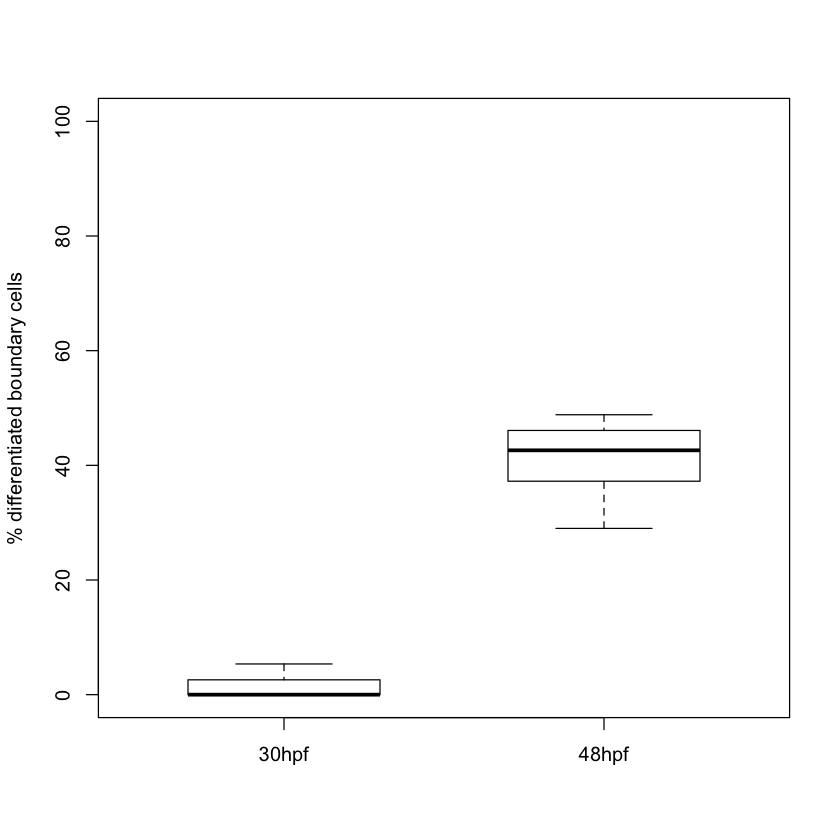

In [63]:
b1 <- diffCounts[diffCounts$time=="30hpf","percHuC"]
b2 <- diffCounts[diffCounts$time=="48hpf","percHuC"]

boxplot(b1,b2, main = "", 
        xlab = "", ylab = "% differentiated boundary cells",
        ylim=c(0,100),
        names =  c("30hpf", "48hpf"), col ="white",
        boxwex=0.6)

descr2groups(b1,b2, nams=c("30hpf", "48hpf"))

\newpage

## Figure 2E

In [64]:
load("data/tracking.RData")


plotLineageTree <- function(sortBy="", selTrackType=NULL, selPlfType=NULL){
  # plot the lineages tree by track and color
  # sortBy can be "", "divTime", "onlyPs", "plfType"
  # selTrackType, can be a list of track types to plot
  # selPlfType, can be a list of plf types to plot  NO BOTH should be given
  tRange=frame2hpf(c(24, 217)) # range(dataset$POSITION_T))
  
    # what cells to plot
  if (length(selTrackType)==0){
    if (length(selPlfType)==0) selTrackType<-sort(unique(cellsTable$trackType))
    else selTrackType <- sort(unique(cellsTable[cellsTable$plfType!="", "trackType"]))
  }
  if (length(selPlfType)==0){
    cellsToPlot=cellsTable[cellsTable$trackType %in% selTrackType, ]
    colsInPlot = cellColor[cellsToPlot$trackType]
  } else { # deal with plfType
    cellsToPlot=cellsTable[cellsTable$plfType %in% selPlfType, ]
    colsInPlot = plfColor[cellsToPlot$plfType]
  }
  tracksInPlot = tracksTable[(tracksTable[,1] %in% cellsToPlot$track) , ]
  firstFrame = apply(tracksInPlot, 1,
                     function(tr){
                       trL=tr[1]
                       return(min(tracks[[trL]][,4]))
                     })
  if (length(selPlfType)==0){
    ord = order(tracksInPlot[,"TrackType"], tracksInPlot[,"divTime"], firstFrame)
    tit = gsub(",", ":", 
               toString(format(t(cbind(selTrackType, cellColor[selTrackType])))))
    titMain = paste("Lineage tree", "for types", toString(selTrackType))
  }
  else{
    ord = order(tracksInPlot[,"plfType"], tracksInPlot[,"divTime"], firstFrame)
    tit = gsub(",", ":", toString(format(t(cbind(selPlfType, plfColor[selPlfType])))))
    titMain = paste("Lineage tree", "for types", toString(selPlfType))
  }
  if (sortBy=="divTime")
    ord = order(tracksInPlot[,"divTime"], firstFrame)
  
  plot(0, 0, 
       xlim = tRange, 
       ylim=c(1,dim(tracksInPlot)[1]),
       main = titMain,
       sub = tit,
       ylab = "Track number", xlab = "Time (hpf)",
       type="n", yaxt="n")
  axis(2, labels = TRUE, tick = TRUE, at = seq(1, dim(tracksInPlot)[1] , by = 1))
  ## no legend
  for (i in 1:dim(cellsToPlot)[1]){
    # color = ""
    tTy = cellsToPlot[i, "trackType"]
    cTy = cellsToPlot[i, "cellType"]
    cLb = cellsToPlot[i, "cellLabel"]
    cTr = cellsToPlot$track[i]
    # ara ha de ser l'index de cTr
    tNum = match(cTr, tracksInPlot[ord,1])
    #if (tNum==5) print(cLb)
    path = cells[[cLb]][,4]
    xinc = c(0, 0.2, -0.2, 0.3, 0.1, 0.2, 0.4)[
      cTy==c("P", "D1", "D2",  "11", "12", "21", "22")]
    lines(x=frame2hpf( path), y=rep(tNum+xinc,length(path)), type="l", 
          col=ifelse(length(selPlfType)==0,
                     cellColor[[ cellsToPlot[i, "trackType"] ]],
                     plfColor[[ cellsToPlot[i, "plfType"] ]]))
    if (cellsToPlot[i,"hasDivision"]){
      points(x=frame2hpf(cellsToPlot[i,"cellLastFrame"]), col=colsInPlot[i][[1]],
             y=tNum+xinc, pch=16,  cex=0.8)
      
    }
  }
}


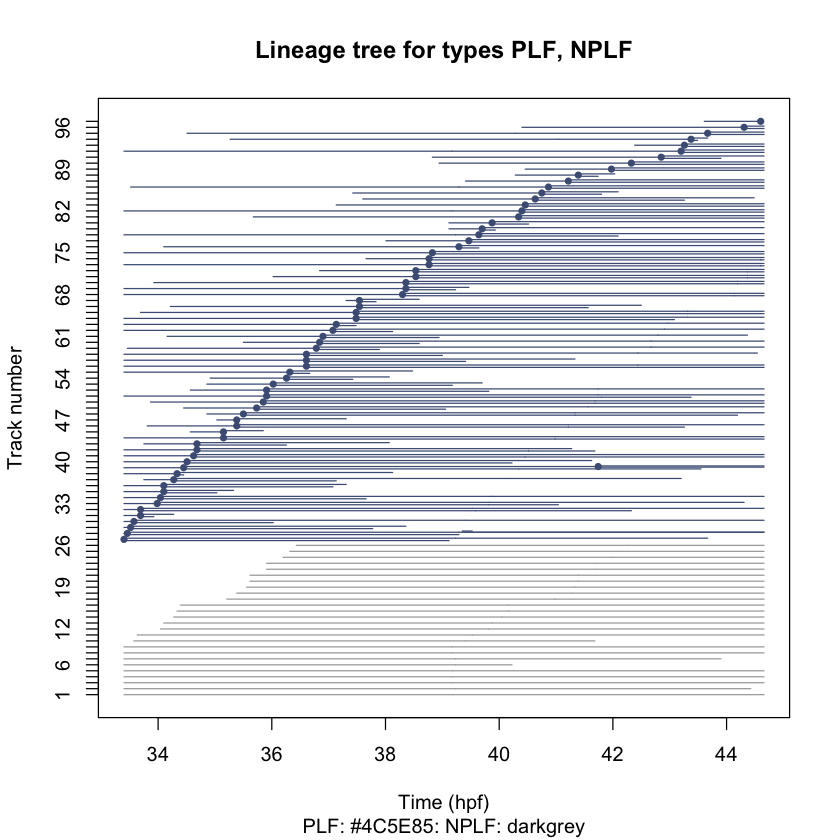

In [65]:

plotLineageTree(selPlfType = c("PLF", "NPLF"))


\newpage

## Figure 3B

In [66]:

# some new colors
cellColor <- list(PQ= "black",PN=  "#2A6684",IND1=  "white",
                  PP="#B74C04", CN="darkgrey", N="darkgrey", NONE="white", 
                  PD="#5D9B90", ND="#95CC86")
plfColor <- list(NPLF="darkgrey", PLF="#4C5E85")



# plot just the not shortLived tracks 
plotLineageTree <- function(sortBy="", selTrackType=NULL){
  # plot the lineages tree by track and color
  # sortBy can be "", "divTime", "onlyPs", "plfType", "LMposition"
  # selTrackType, can be a list of track types to plot
  tRange=frame2hpf(c(24, 217)) #   range(dataset$POSITION_T))
  
  # what cells to plot
  if (length(selTrackType)==0){
    if (length(selPlfType)==0) 
        selTrackType<-sort(unique(cellsTable$trackType))
    else selTrackType <- 
      sort(unique(cellsTable[cellsTable$plfType!="", "trackType"]))
  }
  cellsToPlot <-
    cellsTable[((cellsTable$trackType %in% selTrackType)&(!cellsTable$isShort)), ]
  colsInPlot <-
    cellColor[cellsToPlot$trackType]
  
  tracksInPlot = tracksTable[(tracksTable[,1] %in% cellsToPlot$track) , ]
  firstFrame = apply(tracksInPlot, 1,
                     function(tr){
                       trL=tr[1]
                       return(min(tracks[[trL]][,4]))
                     })
  
    ord = order(tracksInPlot[,"TrackType"], tracksInPlot[,"divTime"], firstFrame)
    tit = gsub(",", ":", 
               toString(format(t(cbind(selTrackType, cellColor[selTrackType])))))
    titMain = paste("Lineage tree", "for types", toString(selTrackType))

  if (sortBy=="divTime")
    ord = order(tracksInPlot[,"divTime"], firstFrame)
  else if (sortBy =="LMposition"){
    divTimes <- tracksInPlot[,"divTime"]
    toSortLM <- apply(tracksInPlot, 1,
                     function(tr){
                       trL <- tr[1]
                       trDivT <- as.numeric(tr[3])
                       trC <- tracks[[trL]]
                       return(trC[trC[,4]==trDivT,1])
                     })
     ord <- order(toSortLM)
  } else {stop("sortBy not implemented")}
  
  plot(0, 0, 
       xlim = tRange, 
       ylim=c(1,dim(tracksInPlot)[1]),
       main = titMain,
       sub = tit,
       ylab = ifelse((sortBy %in% c("LMposition", "TypeLMposition")),
                     "LM position", "Track number") ,
       xlab = "Time (hpf)",
       type="n", yaxt="n")
  if (sortBy=="LMposition"){
    axis(2, labels = round(toSortLM[ord],0), tick = TRUE, 
         at = seq(1, dim(tracksInPlot)[1] , by = 1), 
         las = 1, cex=0.8)
  }
  else if (sortBy=="TypeLMposition"){
    axis(2, labels = round(toSortLM[ord],0), tick = TRUE, 
         at = seq(1, dim(tracksInPlot)[1] , by = 1), las = 1, cex=0.8)
  }
  else axis(2, labels = TRUE, tick = TRUE, 
            at = seq(1, dim(tracksInPlot)[1] , by = 1))
  ## no legend
  for (i in 1:dim(cellsToPlot)[1]){
    tTy = cellsToPlot[i, "trackType"]
    cTy = cellsToPlot[i, "cellType"]
    cLb = cellsToPlot[i, "cellLabel"]
    cTr = cellsToPlot$track[i]
    # ara ha de ser l'index de cTr
    tNum = match(cTr, tracksInPlot[ord,1])
    #if (tNum==5) print(cLb)
    path = cells[[cLb]][,4]
    xinc = c(0, 0.2, -0.2, 0.3, 0.1, 0.2, 0.4)[
      cTy==c("P", "D1", "D2",  "11", "12", "21", "22")]
    cCol <- cellColor[[ cellsToPlot[i, "trackType"] ]]
    
    lines(x=frame2hpf( path), y=rep(tNum+xinc,length(path)), type="l", 
          col=cCol)
    if (cellsToPlot[i,"hasDivision"]){
      points(x=frame2hpf(cellsToPlot[i,"cellLastFrame"]), col=cCol,
             y=tNum+xinc, pch=16,  cex=0.8)
    }
  }
} # end plotLineageTree


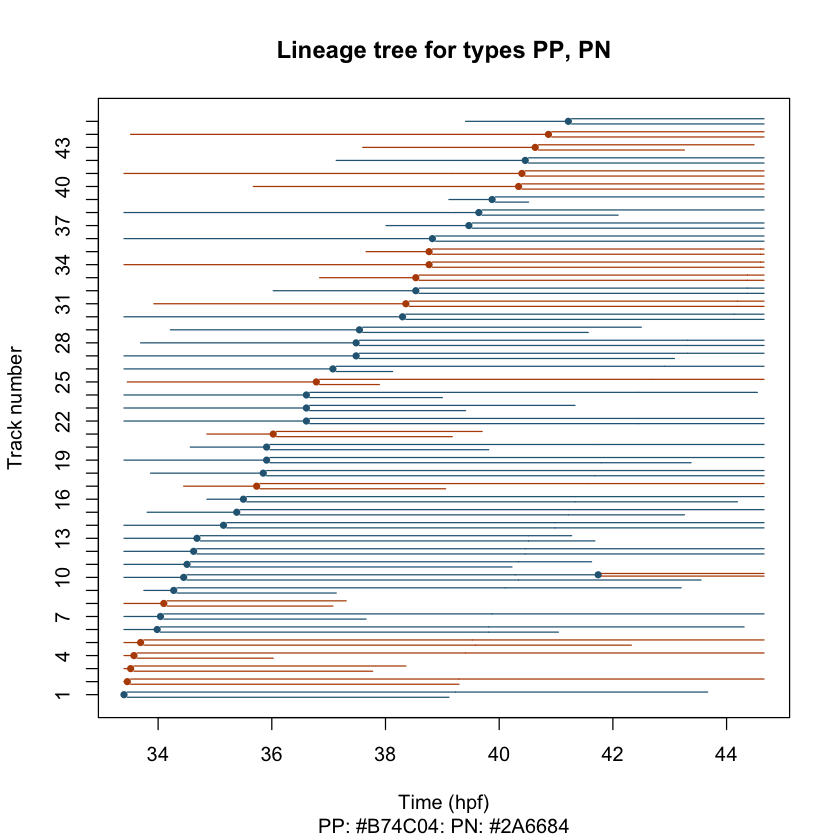

In [67]:
plotLineageTree(selTrackType = c("PP", "PN"), sortBy = "divTime")

\newpage

## Figure 3E

In [68]:

load("data/tracking.RData")

progCells <- cellsTable[cellsTable$trackType %in% c("PN","PP", "PQ"), 
                        "cellLabel"] # 187 cells
# We build an array cells x frames filled by 0/1 
# according if the cell is there on the frame 
# So: isthere(c,f) = ifelse("c is in f", 1, 0) 
# but: A Dx cell is_in a frame if it already has been seen in a previous frame.
# change x to 0/1 according abscence/presence
isthere <- t(vapply(progCells,
                    FUN = function(cn){
                      cF <- cellsTable[cn,"cellFirstFrame"]
                      cL <- cellsTable[cn, "cellLastFrame"]
                      # print(paste(cn, cF, cL))
                      if (cellsTable[cn,"trackType"]=="PQ")
                        c(rep.int(0, cF-24), # 24 is first frame, 217 is last
                          rep.int(1, 217-cF+1))
                      else if (cellsTable[cn,"cellType"] == "P")
                        c(rep.int(0, cF-24),
                          rep.int(1, cL - cF + 1),
                          rep.int(0, 217-cL))
                      else # it is a xD cell
                        c(rep.int(0, cF-24),
                          rep.int(1, 217-cF+1))
                    }, FUN.VALUE = rep.int(0, 194))) # 187 cells x 194 frames
colnames(isthere) <- as.character(24:217)

# colnames are 24 to 217
xvals <- round(frame2hpf( as.numeric(colnames(isthere))),
               1)
cellsToPlot <- isthere[cellsTable[progCells,"trackType"] %in% c("PP","PN"),]
nP <- apply(cellsToPlot[cellsTable[rownames(cellsToPlot),
                                   "cellType"] %in% c("P", "PD", "D1", "D2"),],
            2, sum)
nN <- apply(cellsToPlot[(cellsTable[rownames(cellsToPlot),"cellType"] %in% c("D1", "D2"))
                        & (cellsTable[rownames(cellsToPlot),"trackType"] == "PN"),],
            2, sum)

cellsToPlot <- isthere[cellsTable[progCells,"trackType"]=="PQ",]
nQ <- apply(cellsToPlot,
            2, sum)

totalNPQ1 <- nN+nP+nQ 


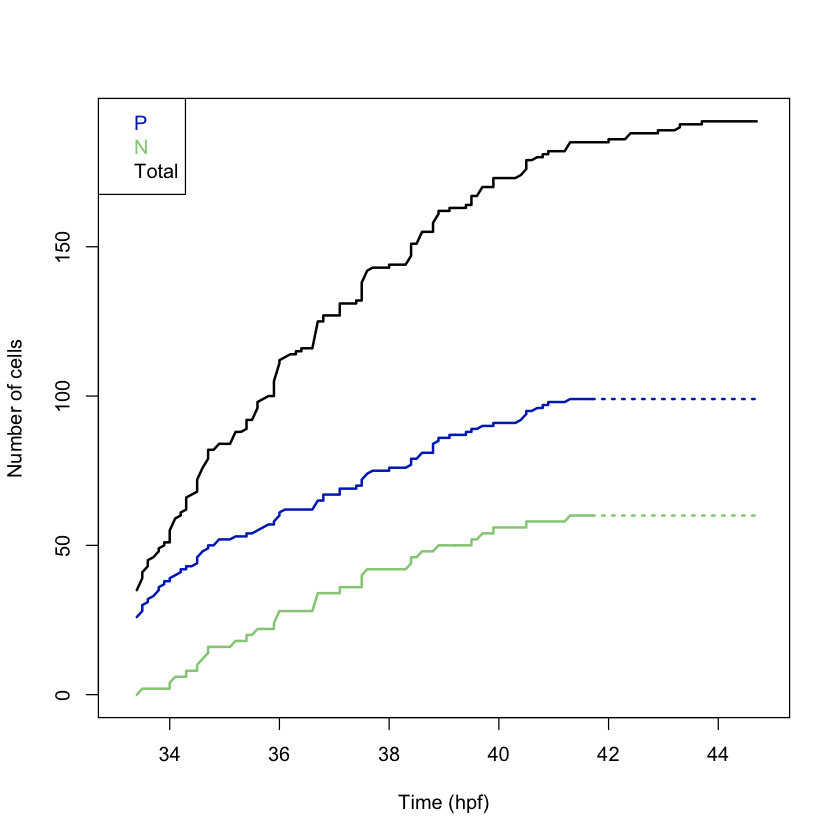

In [69]:
# we split the lines and xvals in two: 1.. 217-51  and 217-51 .. 217
# to not count cell of unknown final fate
ind1 <- ( 24:(217-51)) - 23
ind2 <- ((217-51):217) - 23

xvals1 <- xvals[ind1]
xvals2 <- xvals[ind2]

nN1 <- nN[ind1]
nN2 <- nN[ind2]
nP1 <- nP[ind1]
nP2 <- rep(nP[143], length(ind2))

cellColor <- list(PQ= "black",PN= "#2A6684",IND1= "white", PP="#0031BF", ###"#B74C04",
                  CN="darkgrey", N="darkgrey", NONE="white",
                  PD="#5D9B90", ND="#95CC86")


plot(0,0, type="l", 
     xlim = frame2hpf(c(20,220)), ylim=range(c(nP,nN, totalNPQ1)), 
     xlab = "Time (hpf)", ylab = "Number of cells")
lines(x=xvals1, y=nN1, lwd=2, col = cellColor$ND)
lines(x=xvals2, y=nN2, lwd=2, lty=3, col = cellColor$ND)

lines(x=xvals1, y=nP1, lwd=2, col = cellColor$PP)
lines(x=xvals2, y=nP2, lwd=2, lty=3, col = cellColor$PP)

lines(x=xvals, y=totalNPQ1, lwd=2, col = "black")

legend(x="topleft", legend=c( "P", "N", "Total"), 
       text.col = c(unlist(cellColor[c("PP", "ND")]), "black")
       )


\newpage

## Figure 3H

In [70]:
load("data/ventrSurf.RData")


progCells <- ((cellsTable$trackType %in% c("PP","PN","PQ")) & (cellsTable$cellType != "ND"))

plotAveDistNDvsProg <- function(plotND = TRUE){
  average_wona <- function(frxcl){ # average for each frame skipping NAs
    print(dim(frxcl))
    res <- apply(frxcl, 1, 
                 FUN = function(x){ifelse(all(is.na(x)), NA, mean(x,na.rm = TRUE))})
    return(res)}
  distsProgs <- 
    cellPaths[ , progCells, "dist"] # it is a frame x cells array of distances
  distsND <- 
    cellPaths[, cellsTable$cellType == "ND", "dist"] # it is a frame x cells array of distances
  yyProgs <- average_wona(distsProgs)
  yyND    <- average_wona(distsND)
  xx      <- as.numeric(rownames(distsProgs))
  xx      <- frame2hpf(xx)
  plot(0,0, ylim=c(0,30), xlim=range(xx),
       xlab="Time hpf", ylab="Distance to VS (µm)", 
       main=paste("Average distance to Ventricular Surface"),
       type="l")
  lines(x = xx[!is.na(yyND)], y = yyND[!is.na(yyND)], col = cellColor$ND, lwd=4)
  lines(x = xx[!is.na(yyProgs)], y = yyProgs[!is.na(yyProgs)], col = "#0031BF", lwd=4)
  # return(distsND)
}


[1] 194 157
[1] 194  30


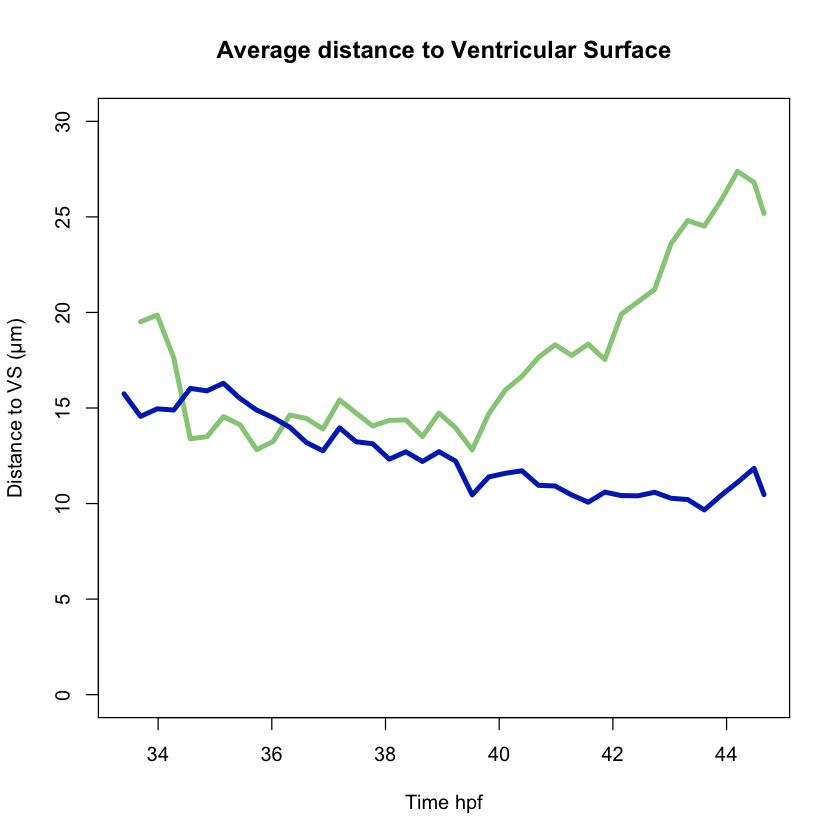

In [71]:

plotAveDistNDvsProg()


\newpage

## Figure 4C

bp notch active 26-36

       N     M   SD  SEM
26hpf 20  9.06 5.41 1.21
36hpf 16 60.62 8.69 2.17
[1] " t.test p-value: 8.60491568290165e-17  *** "


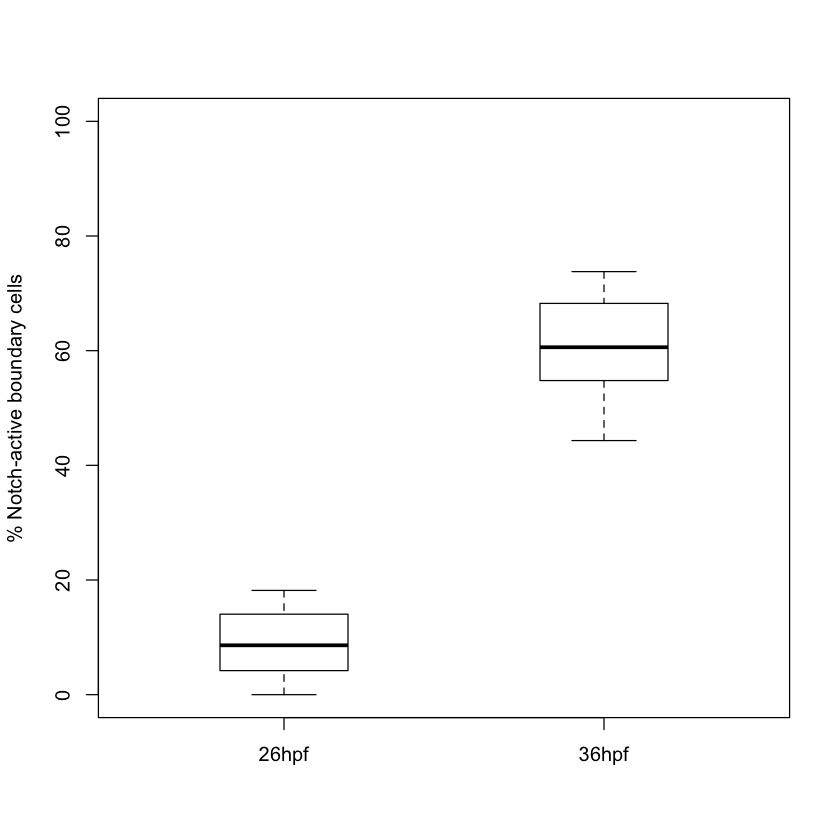

In [72]:
b1 <- percNotch$percNotch[percNotch$time=="26hpf"]
b2 <- percNotch$percNotch[percNotch$time=="36hpf"]
  
boxplot(b1, b2, 
        ylim=c(0,100),
        main = "", xlab = "", 
        ylab = "% Notch-active boundary cells",
        names =  c("26hpf", "36hpf"), col ="white",
        boxwex=0.4, outpch='.', cex=2)

descr2groups(b1,b2, nams=c("26hpf", "36hpf"))

\newpage

## Figure 4 I-J

In [73]:

DMSO <- data.frame(
  HuC = c(7L, 24L, 13L, 21L, 8L, 10L, 8L, 11L),
  Total = c(113L, 132L, 151L, 88L, 125L, 133L, 165L, 101L))
DMSO$percHuC <- DMSO$HuC/DMSO$Total*100
DMSO

HuC,Total,percHuC
<int>,<int>,<dbl>
7,113,6.194690
24,132,18.181818
13,151,8.609272
21,88,23.863636
8,125,6.400000
10,133,7.518797
8,165,4.848485
11,101,10.891089


In [74]:
LY <- data.frame(
  HuC = c(71L, 122L, 82L, 99L, 79L, 142L, 104L, 112L),
  Total = c(74L, 129L, 83L, 101L, 84L, 152L, 110L, 117L))
LY$percHuC <- LY$HuC/LY$Total*100
LY

HuC,Total,percHuC
<int>,<int>,<dbl>
71,74,95.94595
122,129,94.57364
82,83,98.79518
99,101,98.01980
79,84,94.04762
142,152,93.42105
104,110,94.54545
112,117,95.72650


         N     M   SD  SEM
DMSO     8 10.81 6.73 2.38
LY411575 8 95.63 1.91 0.67
[1] " t.test p-value: 4.44043249694964e-10  *** "


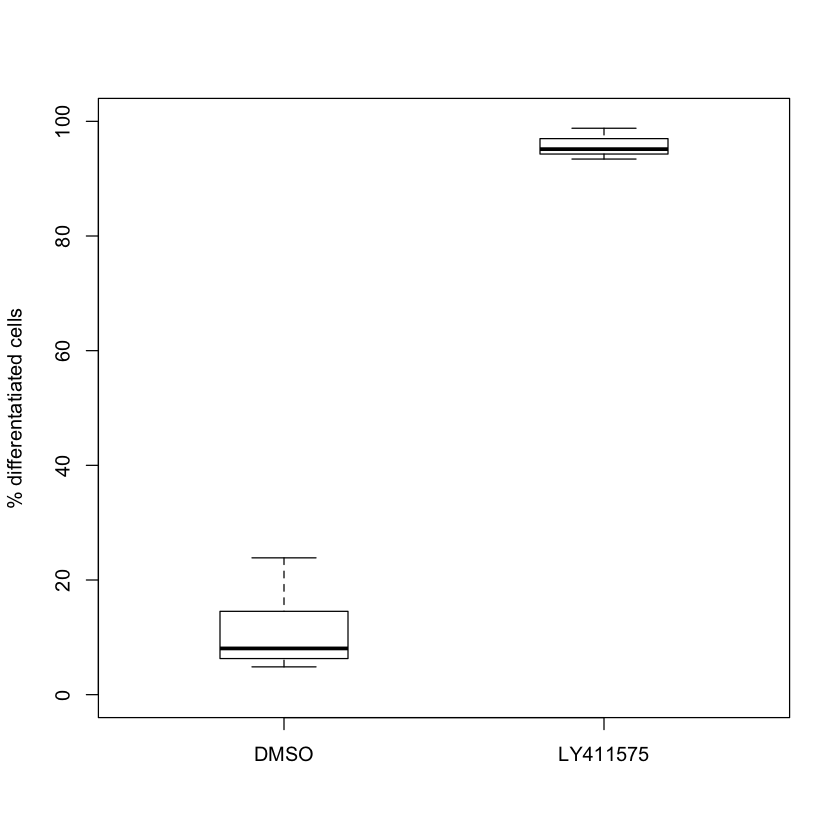

In [75]:
b1 <- DMSO$percHuC
b2 <- DMSO$Total
b3 <- LY$percHuC
b4 <- LY$Total

# fill colors
rellcols <- c("white", "white")

boxplot(b1,b3,
        ylim = c(0,100),
        ylab="% differentatiated cells",
        names = c("DMSO", "LY411575"),
        col = rellcols,
        boxwex=0.4, outpch='.', cex=2)

descr2groups(b1,b3, nams=c("DMSO", "LY411575"), not.paired = TRUE)

         N      M    SD  SEM
DMSO     8 126.00 25.27 8.93
LY411575 8 106.25 26.30 9.30
[1] " t.test p-value: 0.147972179934964 ns"


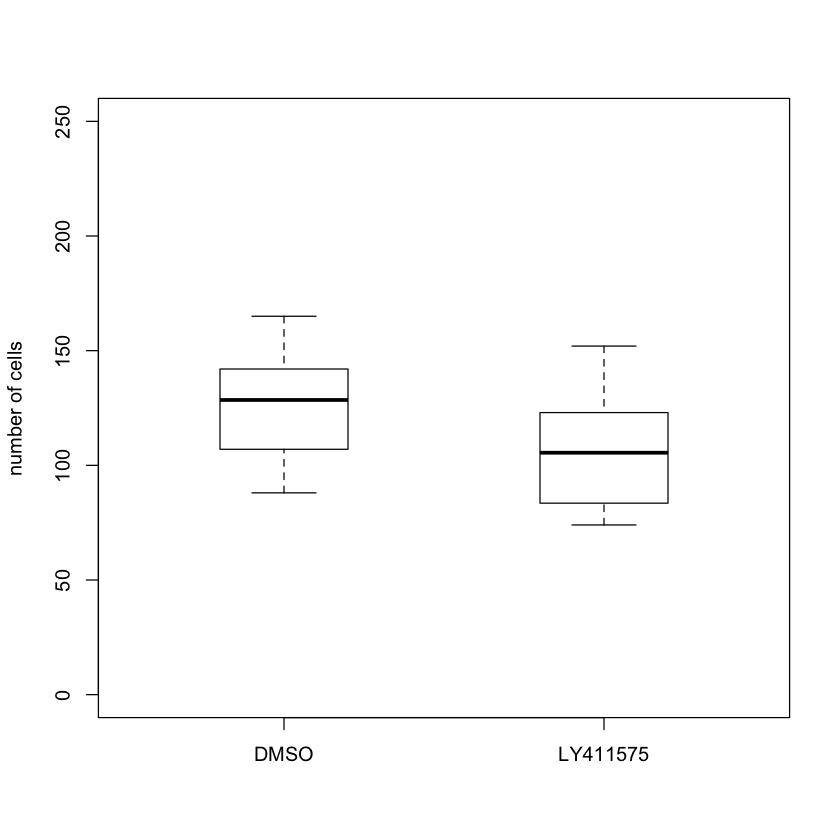

In [76]:
maxRight <- 250

boxplot(b2, b4,
        ylim = c(0, maxRight),
        ylab="number of cells",
        names = c("DMSO", "LY411575"),
        col = rellcols,
        boxwex=0.4, outpch='.', cex=2)

descr2groups(b2,b4, nams=c("DMSO", "LY411575"), not.paired = TRUE)

\newpage

## Figure 7C

       N     M   SD  SEM
48hpf 10 34.92 9.28 2.93
72hpf 10 82.60 4.89 1.55
[1] " t.test p-value: 1.25029141236881e-09  *** "


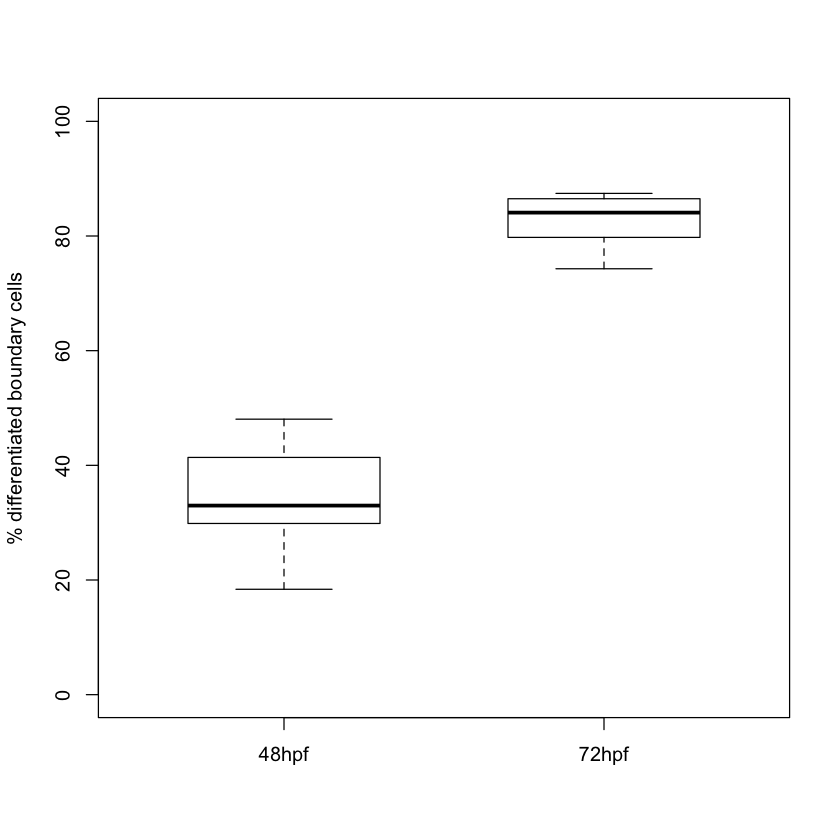

In [77]:

b1 <- diff4872$percHuC[diff4872$time=="48hpf"]
b2 <- diff4872$percHuC[diff4872$time=="72hpf"]
  
boxplot(b1, b2, ylim=c(0,100),
        main = "", xlab = "", 
        ylab = "% differentiated boundary cells",
        names =  c("48hpf", "72hpf"), col ="white",
        boxwex=0.6, outpch='.', cex=2)

descr2groups(b1,b2, nams=c("48hpf", "72hpf"), not.paired = TRUE)

\newpage

## Figure Sup3 A-B

[1] "white"    "darkgray" "white"    "#5D9B90"  "white"    "#48125E"  "white"   
[8] "#c44b16"

[1] "    r2r3"
      N     M   SD  SEM
30hpf 5  0.52 1.17 0.52
48hpf 5 36.94 6.56 2.94
[1] " t.test p-value: 0.00017966409092005  *** "
[1] "    r3r4"
      N     M   SD  SEM
30hpf 5  0.54 1.21 0.54
48hpf 5 45.06 3.93 1.76
[1] " t.test p-value: 3.66182536599032e-06  *** "
[1] "    r4r5"
      N     M   SD  SEM
30hpf 5  1.90 2.64 1.18
48hpf 5 44.19 4.62 2.06
[1] " t.test p-value: 1.1495142048472e-06  *** "
[1] "    r5r6"
      N     M   SD  SEM
30hpf 5  1.58 1.47 0.66
48hpf 5 40.10 5.18 2.32
[1] " t.test p-value: 3.08634422148325e-05  *** "


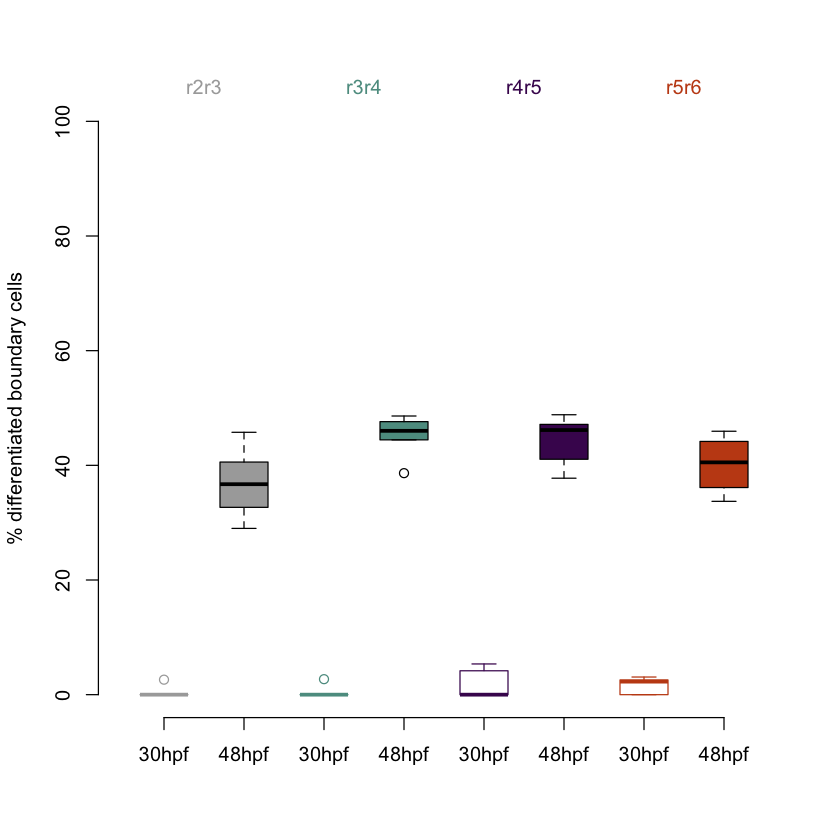

In [78]:
diffCounts$percHuC <- 100*diffCounts$Huc/(diffCounts$Huc+diffCounts$noHuC)

b1<- diffCounts %>% filter(time=="30hpf", bound=="r2r3")
b2 <- diffCounts %>% filter(time=="48hpf", bound=="r2r3")
b3<- diffCounts %>% filter(time=="30hpf", bound=="r3r4")
b4 <- diffCounts %>% filter(time=="48hpf", bound=="r3r4")
b5<- diffCounts %>% filter(time=="30hpf", bound=="r4r5")
b6 <- diffCounts %>% filter(time=="48hpf", bound=="r4r5")
b7<- diffCounts %>% filter(time=="30hpf", bound=="r5r6")
b8 <- diffCounts %>% filter(time=="48hpf", bound=="r5r6")

opar<-par(no.readonly = TRUE)
par(bty="n")

boundaryColors = c("darkgray", "#5D9B90", "#48125E", "#c44b16")
altcols <- paste(rbind(boundaryColors, rep("black",4)))

boxplot(b1$percHuC, b2$percHuC, b3$percHuC, b4$percHuC, 
        b5$percHuC, b6$percHuC, b7$percHuC, b8$percHuC,
        ylab = "% differentiated boundary cells",
        names =  rep(c("30hpf", "48hpf"),4),
        col = paste(rbind(rep("white",4), boundaryColors)),
        boxcol= altcols, medcol = altcols, staplecol = altcols, 
        whiskcol = altcols, outcol = altcols,
        ylim=c(0,100),
        boxwex=0.6
        )
mtext(text=c("r2r3","r3r4", "r4r5", "r5r6"), side=3, 
      at=seq(1.5, 7.5, by=2), col=boundaryColors)

paste(rbind(rep("white",4), boundaryColors))
par(opar)

descr2groups(b1$percHuC,b2$percHuC, tit = "r2r3", nams=c("30hpf", "48hpf"))
descr2groups(b3$percHuC,b4$percHuC, tit = "r3r4", nams=c("30hpf", "48hpf"))
descr2groups(b5$percHuC,b6$percHuC, tit = "r4r5", nams=c("30hpf", "48hpf"))
descr2groups(b7$percHuC,b8$percHuC, tit = "r5r6", nams=c("30hpf", "48hpf"))

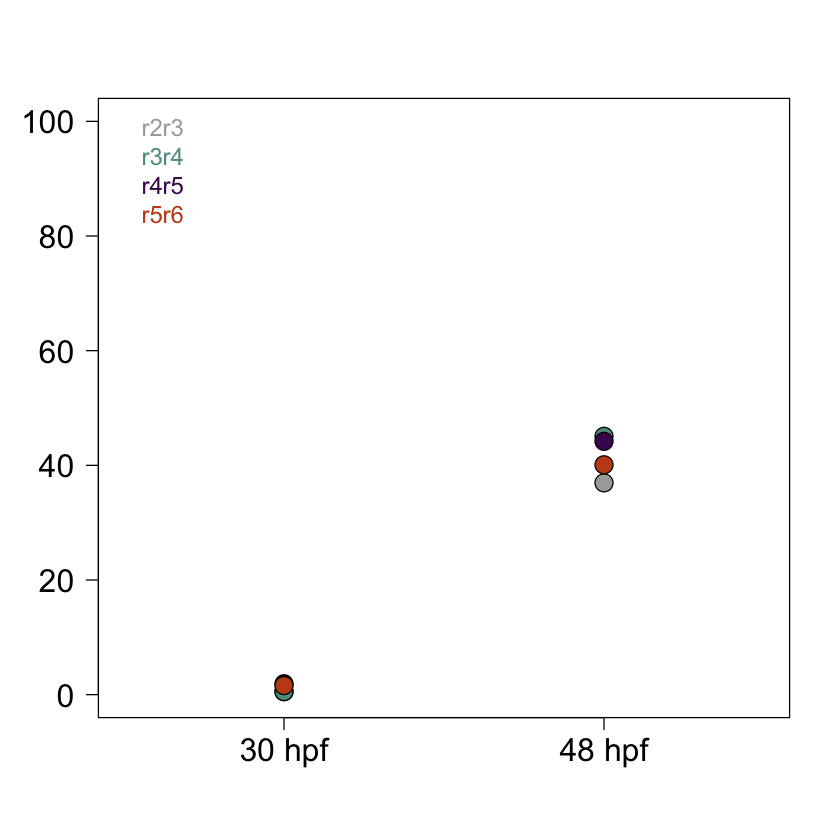

In [79]:
plot(0,0, type="n", xlab="", ylab="",
     xlim=c(0.5,2.5), ylim=c(0,100),
     xaxt="n", yaxt="n")
points(x=rep(1,4), y=percHuC_30, pch=21,cex=2, bg=boundaryColors )
points(x=rep(2,4), y=percHuC_48, pch=21,cex=2, bg=boundaryColors)

axis(1, at=1:2, labels=c("30 hpf", "48 hpf"), cex.axis=1.6)
axis(2, at=seq(0,100,by=20), labels = seq(0,100,by=20), las=2, cex.axis=1.6)

legend(x="topleft",legend = levels(percBoundTime$bound), 
       text.col=boundaryColors, cex=1.2, bty="n")

\newpage

## Figure Sup3 C-D

In [80]:

# load("../VentrSurf21/allButMeshes.RData")
# load("data/ventrSurf.RData")
# source("../VentrSurf21/processVS.R")

#YLIMS <- c(-120,-20)
YLIMS <- c(-120, -75)

plotSectionY <- function(plotOnly=NULL, singleColor=NULL, grayBg=NULL){ 
  # If plotOnly is a frame name, highlight it with singleColor
  # If grayBg can be NULL. If "gray" or "gradient" all VSs are drawn 
  # otherwise, for plotOnly FALSE, paletaCova is used
  # plotArr <- !is.null(addArrows)
  # ylm=YLIMS
  # if (plotArr||plotDivPoints){
  #   ylm[1]<--180
  # }
    ns <- length(secs39)

    if (is.null(grayBg))
    cols <- paletaCova(ns)
    else if (grayBg=="gray")
    cols <- rep(gray(0.8), ns)
    else cols=rev(gray.colors(ns))

  plot(0,0, asp=1,
       xlim = c(25,175), ylim = YLIMS,
       xlab="POS_X L/M", ylab="POS_Z D/V", 
       main=paste("Section A/P at y =", 39),
       type="n")
  
  if (is.null(plotOnly)||(!is.null(grayBg)))
    for (nn in 1:length(secs39)){ # sec is 4 x nsegs, each col is x0,z0,x1,z1
      sec = secs39[[nn]]
      #lines(x=t(sec[c(1,3),]), y=t(sec[c(2,4),]), col=cols[nn])
      ll <- apply(sec, 2, 
                  FUN=function(c4) 
                    lines(x=c4[c(1,3)], y=c4[c(2,4)], 
                          lwd=2,
                          xlim = c(0,175), ylim = c(-120,-20),
                          col=cols[nn]))
    }
  if (!is.null(plotOnly)){
    sec <- secs39[[plotOnly]]
    ll <- apply(sec, 2, 
                FUN=function(c4) 
                  lines(x=c4[c(1,3)], y=c4[c(2,4)], 
                        lwd=4,
                        col=singleColor))
  }
}



# We take 4 frames as representatives
someSecs39 = c("F025", "F085", "F145", "F218")
someCols = paletaCova(5)[1:4]


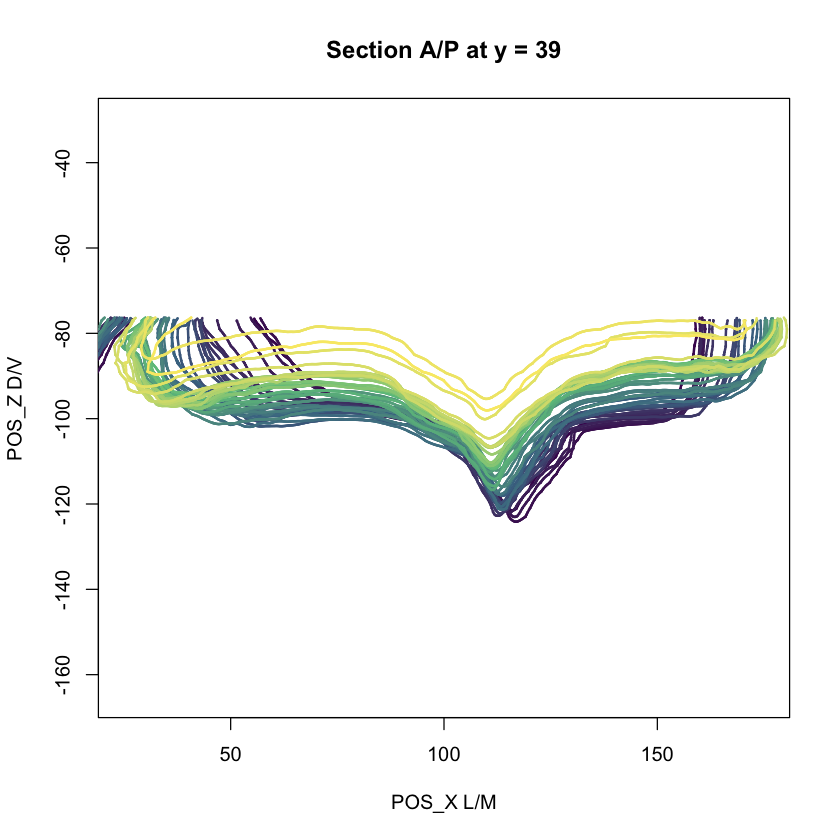

In [81]:
plotSectionY()

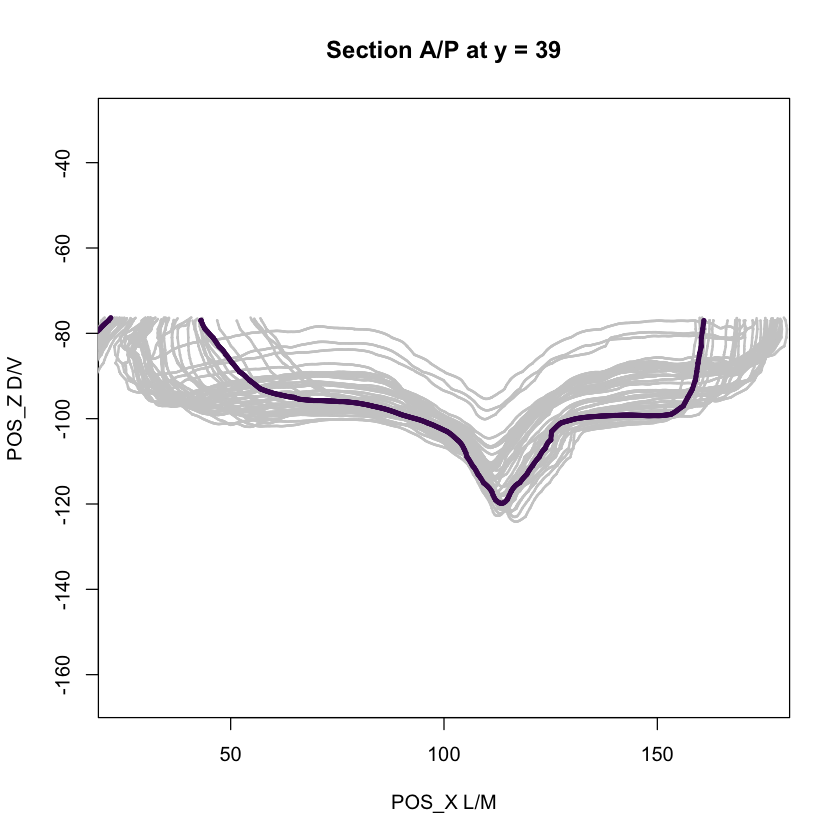

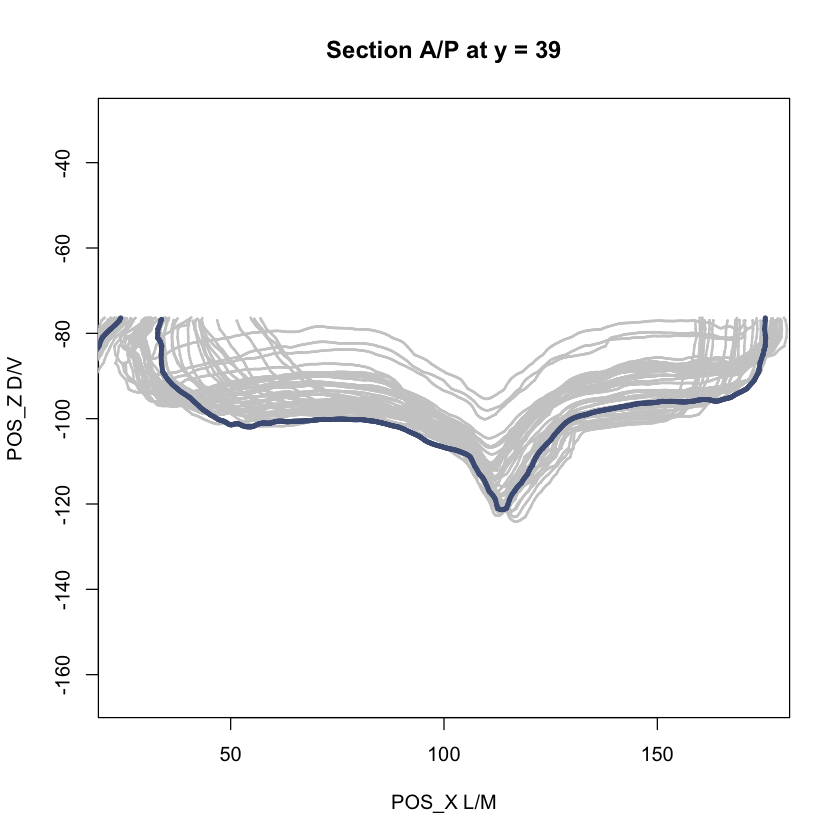

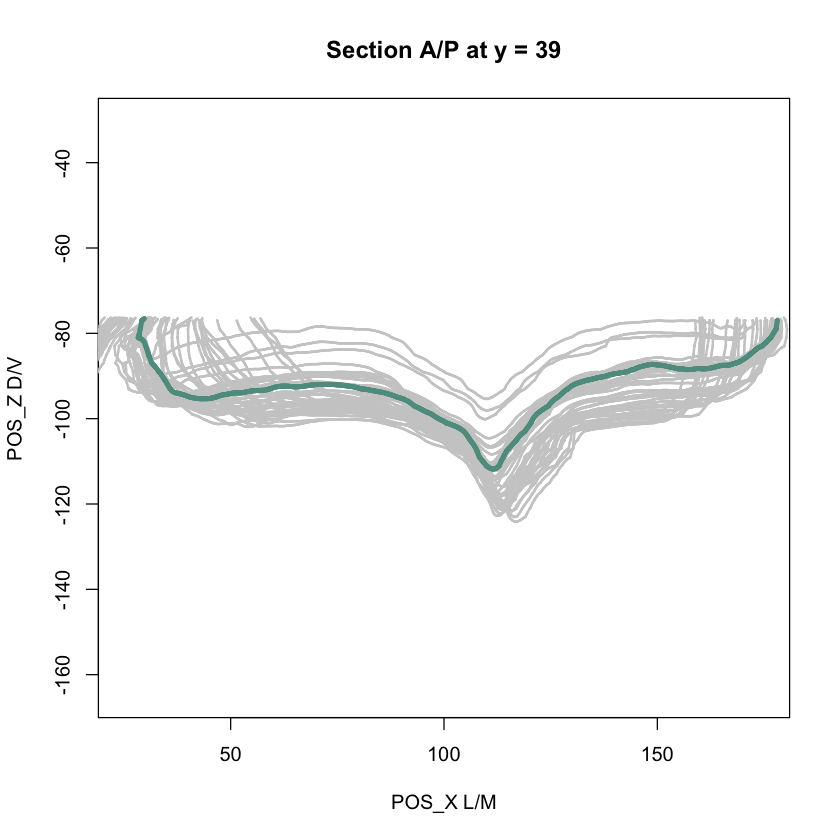

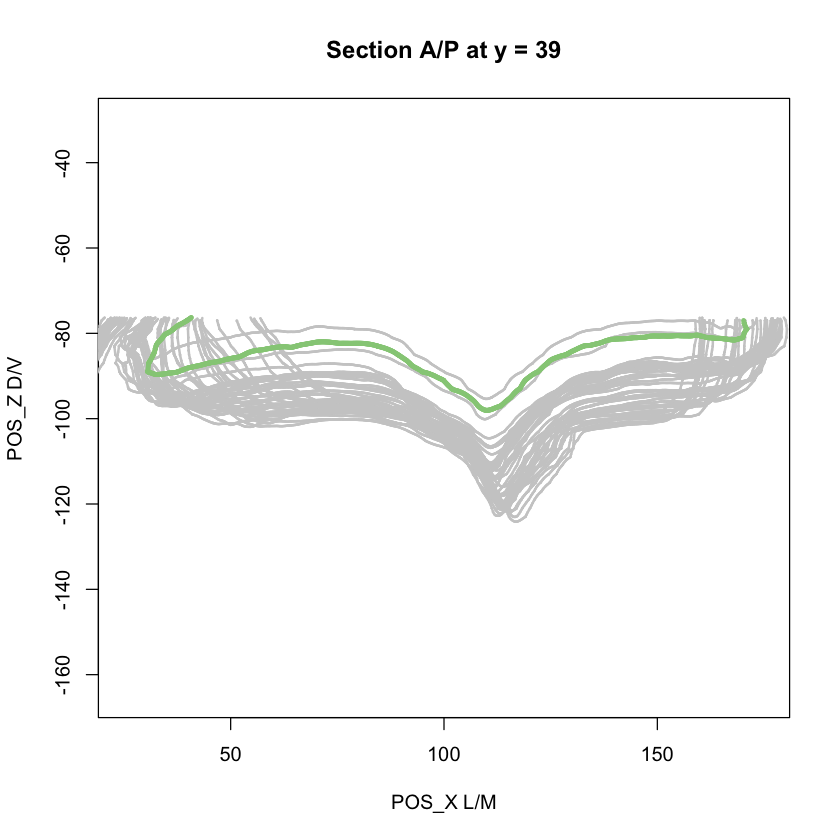

In [82]:
plotSectionY(plotOnly = someSecs39[1], 
             singleColor = someCols[1], grayBg = "gray")
plotSectionY(plotOnly = someSecs39[2], 
             singleColor = someCols[2], grayBg = "gray")
plotSectionY(plotOnly = someSecs39[3], 
             singleColor = someCols[3], grayBg = "gray")
plotSectionY(plotOnly = someSecs39[4], 
             singleColor = someCols[4], grayBg = "gray")


\newpage

## Figure Sup3 E-F

In [83]:
plotPosTrack =
  function(data=cellPaths, what="x", main=what, 
           ave=FALSE, groupByType = "", 
           remark = NULL, noTracks = FALSE){
    # groupByType may be "", or a list of cellTypes
    # remark may be a list of cells to draw its path thicker and with color
    framesT = frame2hpf( as.numeric(dimnames(data)$frame))
    meanNARM <- function(xx) mean(xx,na.rm = TRUE)
    plot(0, 0, 
         xlim = range(framesT),
         ylim= range(data[,,what], na.rm = TRUE),
         main = main,
         sub = "",
         xlab = "Time (hpf)", ylab = what,
         type="n")
    if (any(groupByType=="")){
      if (!noTracks)
        apply(data[,,what], 2, # has 194 x 221
              function(yvals){
                lines(x=framesT[!is.na(yvals)], 
                      y=yvals[!is.na(yvals)],
                      col=gray(0.6))
              })
      if (ave){
        if (what=="x"){ # average left and right
          pth <- apply(data[,,what], 2,meanNARM)
          #print(pth)
          aveR <- apply(data[,(pth>112),what], 1, meanNARM)
          aveL <- apply(data[,(pth<112),what], 1, meanNARM)
          lines(x=framesT[!is.na(aveR)], y=aveR[!is.na(aveR)], 
                col="red", lwd=2)
          lines(x=framesT[!is.na(aveL)], y=aveL[!is.na(aveL)], 
                col="red", lwd=2)
        } else {
          ave0 = apply(data[,,what], 1, meanNARM)
          lines(x=framesT[!is.na(ave0)], y=ave0[!is.na(ave0)], 
                col="red", lwd=2)
        }
      }
    }
    else{ # deal with groupByType
      cols = rainbow(length(groupByType))
      legend(x="topleft",
             legend=groupByType,
             text.col=cols)
      for (cln in names(cells)){
        cTy = cellsTable[cln,"trackType"]
        if (cTy %in% groupByType){
          yvals=data[,cln,what]
          if (!noTracks)
            lines(x=framesT[!is.na(yvals)], y=yvals[!is.na(yvals)],
                  col=ifelse(ave, gray(0.6), 
                             cols[match(cTy, groupByType)]))
        }
      }
      if (ave){
        for (cTy in groupByType){
          wh = cellsTable[,"trackType"]==cTy
          dd=data[,wh,what]
          mdd = apply(dd, 1, meanNARM)
          lines(x=framesT[!is.na(mdd)], y=mdd[!is.na(mdd)], 
              col=cols[match(cTy, groupByType)], lwd=2)
        }
      }
    }
    if (!is.null(remark)){
      for (cl in remark){
        dd <- data[,cl,what]
        lines(x=framesT[!is.na(dd)], y=dd[!is.na(dd)], 
              col=cellColor[[cellsTable[cl, "trackType"]]], lwd=3)
      }
    }
  }

shift_array3 <-
  function(arr, shift=1){ # move all shift down based in first dim 
    rarr = arr
    nro = dim(arr)[1]
    if (shift>0)
      rarr[1:(nro-shift), , ] = arr[(1+shift):nro, , ]
    else # shift<0
      rarr[(1-shift):nro, , ] = arr[1:(nro+shift), , ]
    return(rarr)
  }

mav_paths <-
  # do a moving average over path coordinates
  function(data=cellPaths, mavSize=5){
    if (!(floor(mavSize/2)+0.5==mavSize/2))
      stop(paste("mavSize", mavSize, "should be odd number"))
    halfSize = floor(mavSize/2)
    res = data[1+halfSize:(dim(data)[1]-halfSize), , ]
    for (shi in 1:halfSize) {
      sa = shift_array3(data,shift = shi)
      res = res + sa[1+halfSize:(dim(data)[1]-halfSize), , ]
      sa = shift_array3(data,shift = -shi)
      res = res + sa[1+halfSize:(dim(data)[1]-halfSize), , ]
    }
    return(res/mavSize)
  }

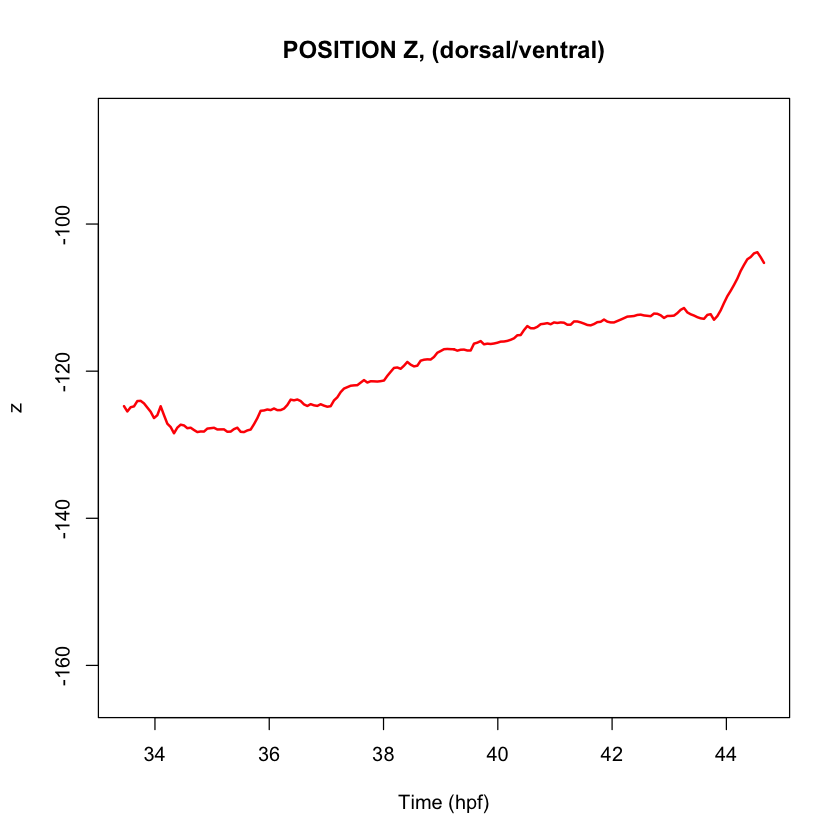

In [84]:

mavCellPaths = mav_paths(cellPaths, mavSize = 3)

plotPosTrack(data=mavCellPaths[,progCells,],
             what="z", main="POSITION Z, (dorsal/ventral)", 
             ave = TRUE, noTracks = TRUE)


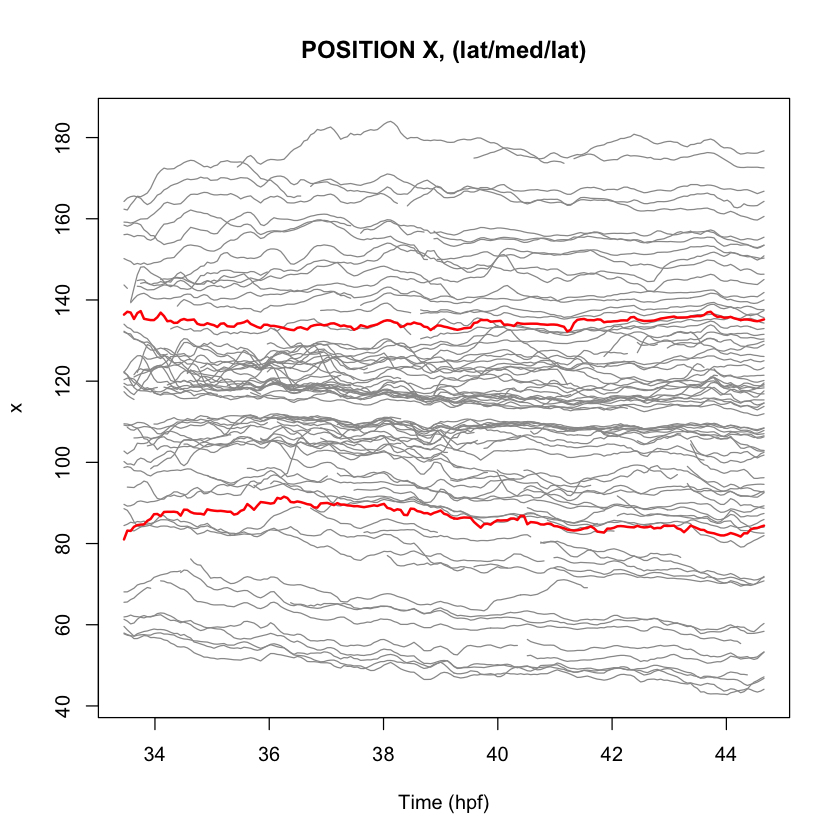

In [85]:
plotPosTrack(data=mavCellPaths[,progCells,], what="x", 
             main="POSITION X, (lat/med/lat)", ave = TRUE)

\newpage

## Figure Sup 3 G

#### Data on number of cell divisions by type and hour pf.

In [86]:
numdivs <- data.frame(
  hpf = c(30L,31L,32L,33L,34L,35L,36L,
          37L,38L,39L,40L,41L,42L,43L,44L,45L,46L,47L,48L,
          49L,50L,51L,52L,53L,54L,55L,56L,57L,58L,59L,60L),
  PN = c(0L,0L,4L,0L,1L,2L,1L,1L,1L,
         0L,0L,0L,0L,0L,0L,0L,0L,0L,0L,0L,0L,0L,0L,0L,
         0L,0L,0L,0L,0L,0L,0L),
  PP = c(0L,0L,1L,2L,2L,1L,0L,5L,5L,
         0L,0L,1L,0L,1L,0L,0L,0L,0L,0L,0L,0L,0L,1L,0L,
         0L,0L,0L,0L,0L,0L,0L),
  Ind = c(0L,0L,3L,9L,15L,16L,18L,16L,
          16L,8L,3L,2L,6L,5L,2L,2L,0L,0L,0L,0L,3L,0L,
          1L,0L,0L,1L,0L,0L,0L,1L,0L),
  nB = c(5L,5L,5L,5L,5L,5L,5L,5L,5L,
         5L,5L,5L,5L,5L,5L,5L,2L,2L,2L,2L,2L,2L,2L,2L,
         2L,2L,2L,2L,2L,2L,2L)
)
#add totals
numdivs$tot <- apply(numdivs[,2:4], 1, sum)

numdivs

hpf,PN,PP,Ind,nB,tot
<int>,<int>,<int>,<int>,<int>,<int>
30,0,0,0,5,0
31,0,0,0,5,0
32,4,1,3,5,8
33,0,2,9,5,11
34,1,2,15,5,18
35,2,1,16,5,19
36,1,0,18,5,19
37,1,5,16,5,22
38,1,5,16,5,22


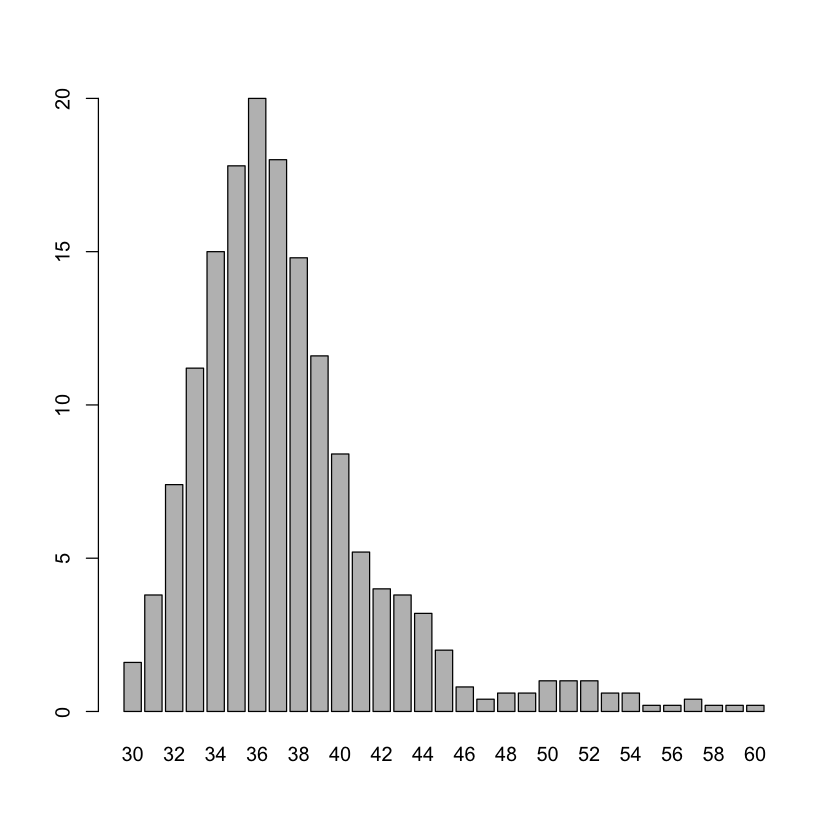

In [87]:
# library(zoo)
mav5numdivs <- zoo::rollmean(c(0,0,numdivs$tot,0,0),5)

barplot( mav5numdivs,
        main = "", names.arg = 30:60)

\newpage

## Figure Sup 4 A-B

notch active vs bound and 26-36 hpf

[1] "    r2r3"
      N     M   SD  SEM
30hpf 5  9.22 5.86 2.62
48hpf 4 66.22 7.56 3.78
[1] " t.test p-value: 2.74404565196448e-05  *** "
[1] "    r3r4"
      N     M    SD  SEM
30hpf 5 12.64  3.74 1.67
48hpf 4 57.73 10.30 5.15
[1] " t.test p-value: 0.00170158398092096  ** "
[1] "    r4r5"
      N     M   SD  SEM
30hpf 5  6.73 5.23 2.34
48hpf 4 54.74 5.06 2.53
[1] " t.test p-value: 3.56889512735125e-06  *** "
[1] "    r5r6"
      N     M   SD  SEM
30hpf 5  7.67 6.16 2.75
48hpf 4 63.79 8.75 4.37
[1] " t.test p-value: 8.70923321486027e-05  *** "


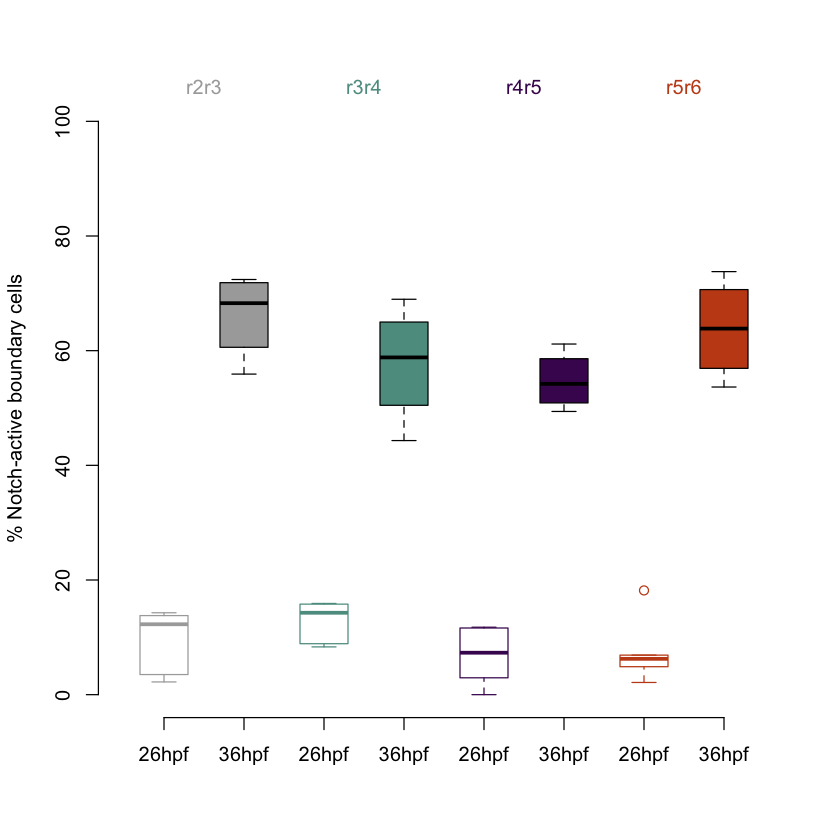

In [88]:

pw_percNotch <-pivot_wider(percNotch, names_from = c(time, bound), values_from = percNotch)

opar<-par(no.readonly = TRUE)
par(bty="n")

boxplot(pw_percNotch[,c(2,6,3,7,4,8,5,9)],
        ylab = "% Notch-active boundary cells",
        names =  rep(c("26hpf", "36hpf"),4),
        boxlty=rep(1,8),
        col = c("white", boundaryColors[1], "white", boundaryColors[2],
                 "white", boundaryColors[3], "white", boundaryColors[4] ),
        boxcol= altcols, medcol = altcols, staplecol = altcols, 
        whiskcol = altcols, outcol = altcols,
        ylim=c(0,100),
        boxwex=0.6
        )

mtext(text=c("r2r3","r3r4", "r4r5", "r5r6"), side=3, 
      at=seq(1.5, 7.5, by=2), col=boundaryColors)
par(opar)

descr2cols(pw_percNotch[,c(2,6)], tit = "r2r3", nams=c("30hpf", "48hpf"))
descr2cols(pw_percNotch[,c(3,7)], tit = "r3r4", nams=c("30hpf", "48hpf"))
descr2cols(pw_percNotch[,c(4,8)], tit = "r4r5", nams=c("30hpf", "48hpf"))
descr2cols(pw_percNotch[,c(5,9)], tit = "r5r6", nams=c("30hpf", "48hpf"))

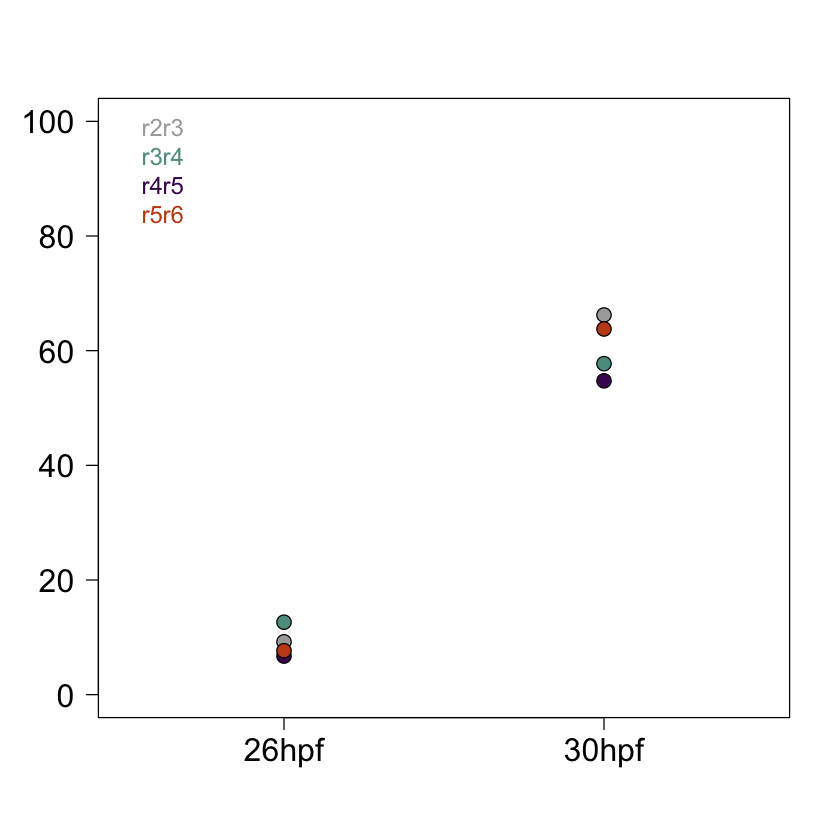

In [89]:
plot(NULL,NULL, type="n",
     xlim=c(0.5,2.5), ylim=c(0,100),
     xaxt="n", yaxt="n",
     main= "",
     xlab="", ylab="") #, ylab="% of Notch-active cells by boundary")
points(x=ifelse(percBoundTimeNotch$time=="26hpf",1,2), 
       y=percBoundTimeNotch$percNotch,
       pch=21,cex=1.6,bg=rep(boundaryColors,each=2))

legend(x="topleft",legend = levels(percBoundTime$bound), 
       text.col=boundaryColors, cex=1.2, bty="n")
axis(1,at=1:2,labels = c("26hpf","30hpf"), cex.axis=1.6)

axis(2, at=seq(0,100,by=20), labels = seq(0,100,by=20), las=2, cex.axis=1.6)

\newpage

## Figure Sup 6A

       N     M    SD   SEM
48hpf 10 150.8 26.11  8.26
72hpf 10 178.5 42.73 13.51
[1] " t.test p-value: 0.100837106653853 ns"


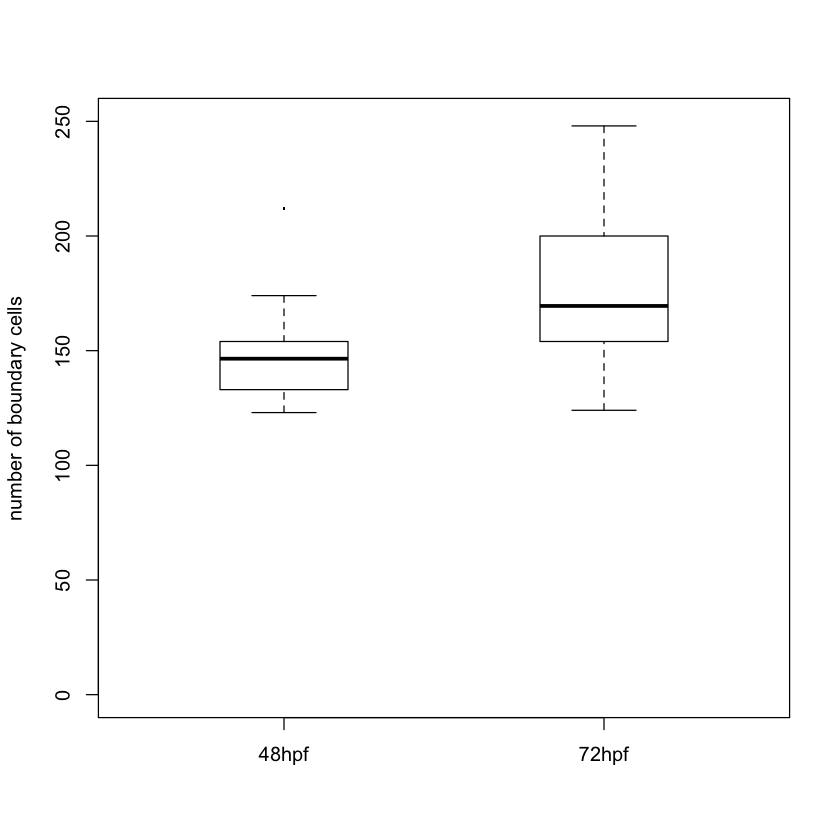

In [90]:

tot48 <- diff4872$nCells[diff4872$time=="48hpf"]
tot72 <- diff4872$nCells[diff4872$time=="72hpf"]

boxplot(tot48, tot72, 
        ylim = c(0,maxRight),
        xlab="", ylab = "number of boundary cells", 
        names = c("48hpf", "72hpf"),
        col = rep("white",2),
        boxwex=0.4, outpch='.', cex=2)

# descripcion total number of cells
descr2groups(tot48, tot72, nams = c("48hpf", "72hpf"), not.paired=TRUE)